**Google Drive Mount**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Load packages**

In [ ]:
import tensorflow.keras.activations as Act

In [ ]:
import tensorflow as tf


In [ ]:
import keras.layers as Layers
import keras.activations as Activations

In [ ]:
import tensorflow.keras.layers as Layers
import tensorflow.keras.activations as Activations
import tensorflow.keras.models as Models
import tensorflow.keras.optimizers as Optimizer
import tensorflow.keras.metrics as Metrics
import tensorflow.keras.utils as Utils
from keras.utils.vis_utils import model_to_dot
import os
import matplotlib.pyplot as plot
import cv2
import numpy as np
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix as CM
from random import randint
#from IPython.display import SVG
import matplotlib.gridspec as gridspec

Now, We need to prepare our data to feed into the model. There is a builtin method in [Keras](https://keras.io/preprocessing/image/) that can extract your images from folders. 

Following is the gernalized function used to extract data from the directory.

In [ ]:
def get_images(directory):
    Images = []
    Labels = []  
    label = 0
    
    for labels in os.listdir(directory): #Main Directory where each class label is present as folder name.
        if labels == 'Normal': 
            label = 0
        elif labels == 'COVID-19':
            label = 1 
        for image_file in os.listdir(directory+labels): #Extracting the file name of the image from Class Label folder
            image = cv2.imread(directory+labels+r'/'+image_file) #Reading the image (OpenCV)
            image = cv2.resize(image,(150,150)) #Resize the image, Some images are different sizes. (Resizing is very Important)
            Images.append(image)
            Labels.append(label)
    
    return shuffle(Images,Labels,random_state=12345) #Shuffle the dataset you just prepared.

def get_classlabel(class_code):
    labels = {0:'Normal', 1:'COVID-19'}
    return labels[class_code]

In [18]:
Images, Labels = get_images('/content/drive/MyDrive/Radiology_workshop_monjoy2/classification_raw_data/train_data/') #Extract the training images from the folders.

Images = np.array(Images) #converting the list of images to numpy array.
Labels = np.array(Labels)

In [19]:
Labels


array([1, 0, 0, ..., 1, 1, 0])

In [20]:

Images.shape

(1684, 150, 150, 3)

Lets find shape of our traing data.

As you see, The Training data is in shape of (Number of Training Images, Width of image, Height of image, Channel of image). This shape is very important. If you didnot resize the images to same size. It should be (No. of images,) shape. So, using this shape you cant feed the images to the model.

In [21]:
print("Shape of Images:",Images.shape)
print("Shape of Labels:",Labels.shape)

Shape of Images: (1684, 150, 150, 3)
Shape of Labels: (1684,)


Let us look some random images of our dataset.

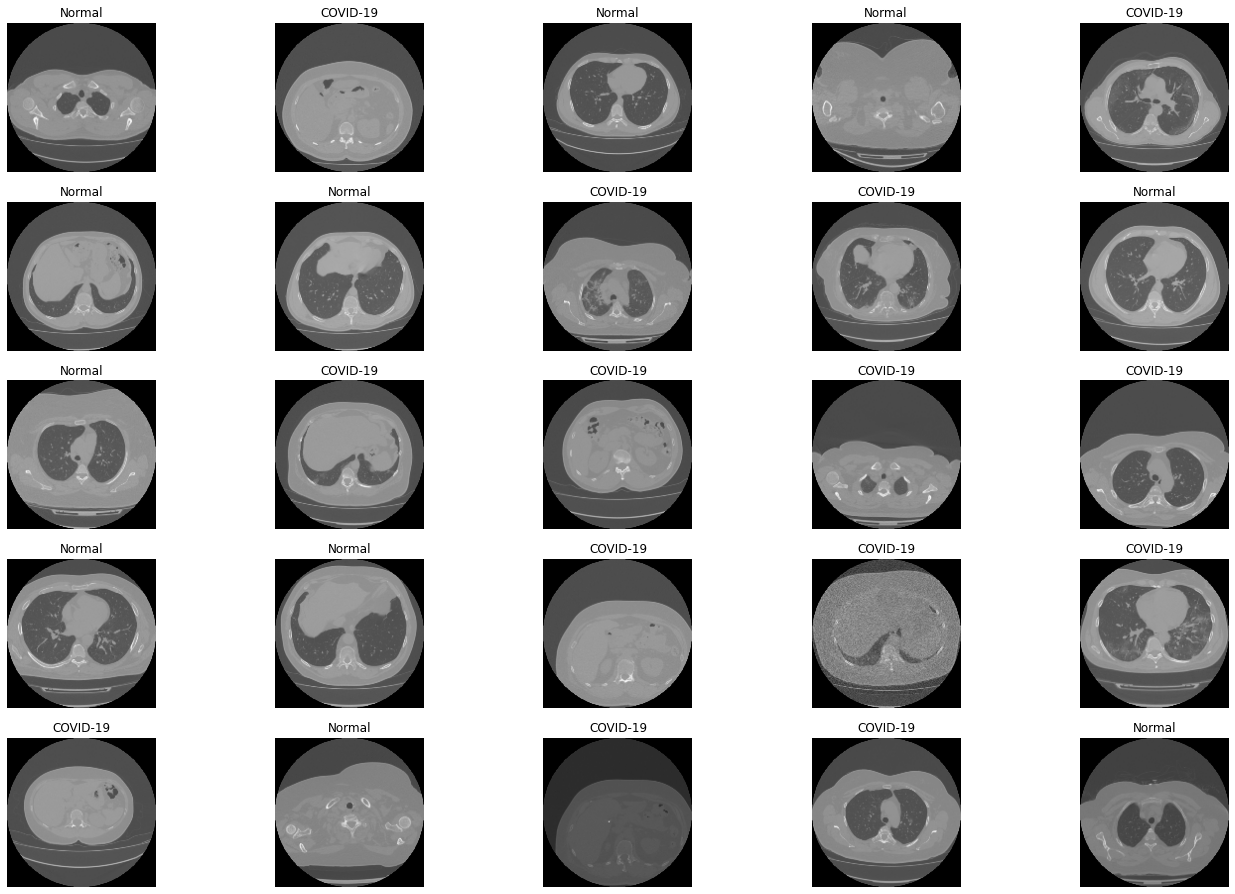

In [22]:
f,ax = plot.subplots(5,5) 
f.subplots_adjust(0,0,3,3)
for i in range(0,5,1):
    for j in range(0,5,1):
        rnd_number = randint(0,len(Images))
        ax[i,j].imshow(Images[rnd_number])
        ax[i,j].set_title(get_classlabel(Labels[rnd_number]))
        ax[i,j].axis('off')

Now, Create the CNN model to predict the class labels.This is the basic CNN model.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 200)     5600      
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 180)     324180    
                                                                 
 conv2d_2 (Conv2D)           (None, 144, 144, 180)     291780    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 28, 28, 180)      0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 180)       291780    
                                                                 
 conv2d_4 (Conv2D)           (None, 24, 24, 140)       226940    
                                                        

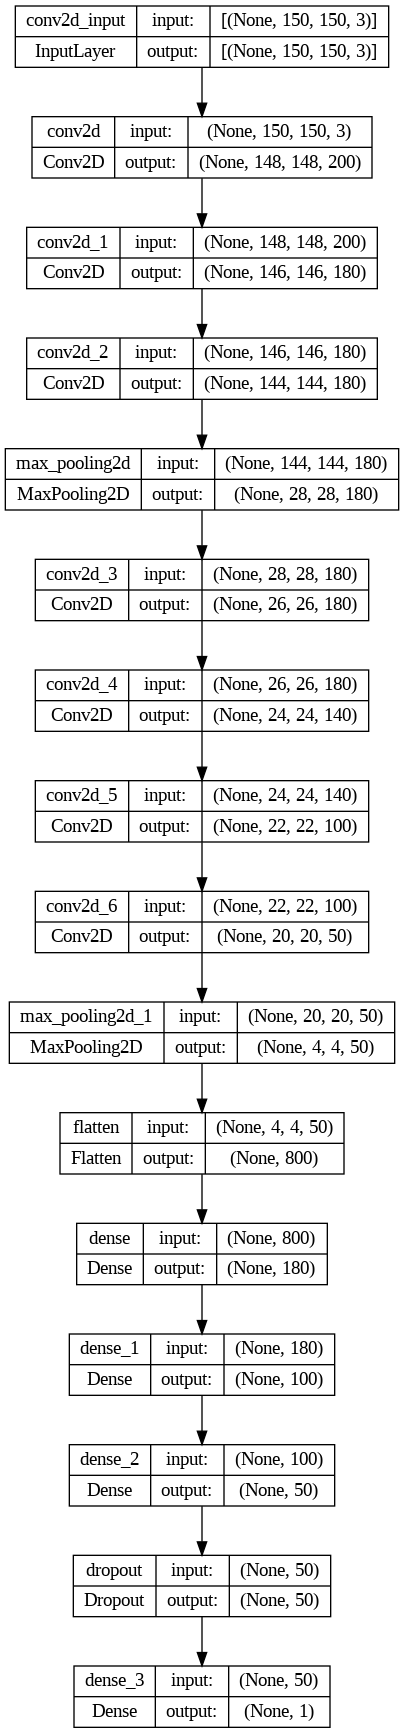

In [23]:
model = Models.Sequential()
model.add(Layers.Conv2D(200,kernel_size=(3,3),activation='relu',input_shape=(150,150,3)))
model.add(Layers.Conv2D(180,kernel_size=(3,3),activation='relu'))
model.add(Layers.Conv2D(180,kernel_size=(3,3),activation='relu'))
model.add(Layers.MaxPool2D(5,5))
model.add(Layers.Conv2D(180,kernel_size=(3,3),activation='relu'))
model.add(Layers.Conv2D(140,kernel_size=(3,3),activation='relu'))
model.add(Layers.Conv2D(100,kernel_size=(3,3),activation='relu'))
model.add(Layers.Conv2D(50,kernel_size=(3,3),activation='relu'))
model.add(Layers.MaxPool2D(5,5))
model.add(Layers.Flatten())
model.add(Layers.Dense(180,activation='relu'))
model.add(Layers.Dense(100,activation='relu'))
model.add(Layers.Dense(50,activation='relu'))
model.add(Layers.Dropout(rate=0.5))
model.add(Layers.Dense(1,activation='sigmoid'))

model.compile(optimizer=Optimizer.Adam(lr=0.0001),loss='binary_crossentropy',metrics=['accuracy'])

model.summary()
#SVG(model_to_dot(model).create(prog='dot', format='svg'))
Utils.plot_model(model,to_file='model.png',show_shapes=True)

Now, lets train the model with validation split equal to 30% from training data. Validation split is used to determine that our model is not geting over-fitted.

In [25]:
import tensorflow as tf
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "./output/cp_NEW-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights every 1 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=10)

# Save the weights using the `checkpoint_path` format
model.save_weights(checkpoint_path.format(epoch=0))

# Train the model with the new callback
trained = model.fit(Images,Labels,batch_size= 5, epochs=100,callbacks=[cp_callback],validation_split=0.20, verbose=1) #verbose meaning using or expressed in more words than are needed.


Streaming output truncated to the last 5000 lines.
209/270 [======================>.......] - ETA: 5s - loss: 0.6920 - accuracy: 0.5254
Epoch 11: saving model to ./output/cp_NEW-0011.ckpt
219/270 [=======================>......] - ETA: 4s - loss: 0.6918 - accuracy: 0.5269
Epoch 11: saving model to ./output/cp_NEW-0011.ckpt
229/270 [========================>.....] - ETA: 3s - loss: 0.6917 - accuracy: 0.5284
Epoch 11: saving model to ./output/cp_NEW-0011.ckpt
239/270 [=========================>....] - ETA: 2s - loss: 0.6918 - accuracy: 0.5280
Epoch 11: saving model to ./output/cp_NEW-0011.ckpt
249/270 [==========================>...] - ETA: 1s - loss: 0.6921 - accuracy: 0.5261
Epoch 11: saving model to ./output/cp_NEW-0011.ckpt
259/270 [===========================>..] - ETA: 1s - loss: 0.6917 - accuracy: 0.5290
Epoch 11: saving model to ./output/cp_NEW-0011.ckpt
269/270 [============================>.] - ETA: 0s - loss: 0.6915 - accuracy: 0.5301
Epoch 11: saving model to ./output/cp_NEW-

In [26]:
!ls {checkpoint_dir}
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

checkpoint			      cp_NEW-0050.ckpt.index
cp_NEW-0000.ckpt.data-00000-of-00001  cp_NEW-0051.ckpt.data-00000-of-00001
cp_NEW-0000.ckpt.index		      cp_NEW-0051.ckpt.index
cp_NEW-0001.ckpt.data-00000-of-00001  cp_NEW-0052.ckpt.data-00000-of-00001
cp_NEW-0001.ckpt.index		      cp_NEW-0052.ckpt.index
cp_NEW-0002.ckpt.data-00000-of-00001  cp_NEW-0053.ckpt.data-00000-of-00001
cp_NEW-0002.ckpt.index		      cp_NEW-0053.ckpt.index
cp_NEW-0003.ckpt.data-00000-of-00001  cp_NEW-0054.ckpt.data-00000-of-00001
cp_NEW-0003.ckpt.index		      cp_NEW-0054.ckpt.index
cp_NEW-0004.ckpt.data-00000-of-00001  cp_NEW-0055.ckpt.data-00000-of-00001
cp_NEW-0004.ckpt.index		      cp_NEW-0055.ckpt.index
cp_NEW-0005.ckpt.data-00000-of-00001  cp_NEW-0056.ckpt.data-00000-of-00001
cp_NEW-0005.ckpt.index		      cp_NEW-0056.ckpt.index
cp_NEW-0006.ckpt.data-00000-of-00001  cp_NEW-0057.ckpt.data-00000-of-00001
cp_NEW-0006.ckpt.index		      cp_NEW-0057.ckpt.index
cp_NEW-0007.ckpt.data-00000-of-00001  cp_NEW-0058.ckpt.data-00

'./output/cp_NEW-0100.ckpt'

**Load a Trained Model**

In [27]:
chk_path= './output/cp_NEW-0080.ckpt'
# Load the previously saved weights
model.load_weights(chk_path)

**Plot Training and Testing Graphs**

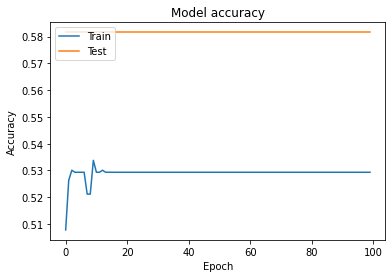

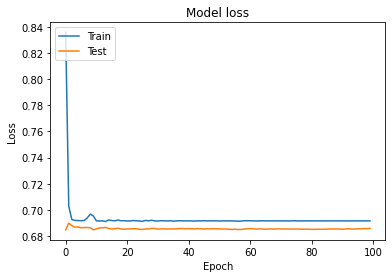

In [28]:
plot.plot(trained.history['accuracy'])
plot.plot(trained.history['val_accuracy'])
plot.title('Model accuracy')
plot.ylabel('Accuracy')
plot.xlabel('Epoch')
plot.legend(['Train', 'Test'], loc='upper left')
plot.show()

plot.plot(trained.history['loss'])
plot.plot(trained.history['val_loss'])
plot.title('Model loss')
plot.ylabel('Loss')
plot.xlabel('Epoch')
plot.legend(['Train', 'Test'], loc='upper left')
plot.show()

To evaluate a model, there are many methods are proposed to evaluate the model. I use Accuracy to evaluate the performance of my model.

In [29]:
test_images,test_labels = get_images('/content/drive/MyDrive/Radiology_workshop_monjoy2/classification_raw_data/test_data/')
test_images = np.array(test_images)
test_labels = np.array(test_labels)
model.evaluate(test_images,test_labels, verbose=1)

1/1 [==============================] - 2s 2s/step - loss: 0.7034 - accuracy: 0.4286


[0.7034158706665039, 0.4285714328289032]

Lets predict the images from the "pred" folder.

In [30]:
y_pred = model.predict(test_images)
y_pred= y_pred.round()
#y_pred

1/1 [==============================] - 0s 190ms/step


In [31]:
len(test_labels)

21

**Generate a classification report**

In [32]:
from sklearn.metrics import classification_report
report = classification_report(test_labels, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.43      1.00      0.60         9
           1       0.00      0.00      0.00        12

    accuracy                           0.43        21
   macro avg       0.21      0.50      0.30        21
weighted avg       0.18      0.43      0.26        21



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Plot Prediction Results**

1/1 [==============================] - 0s 23ms/step


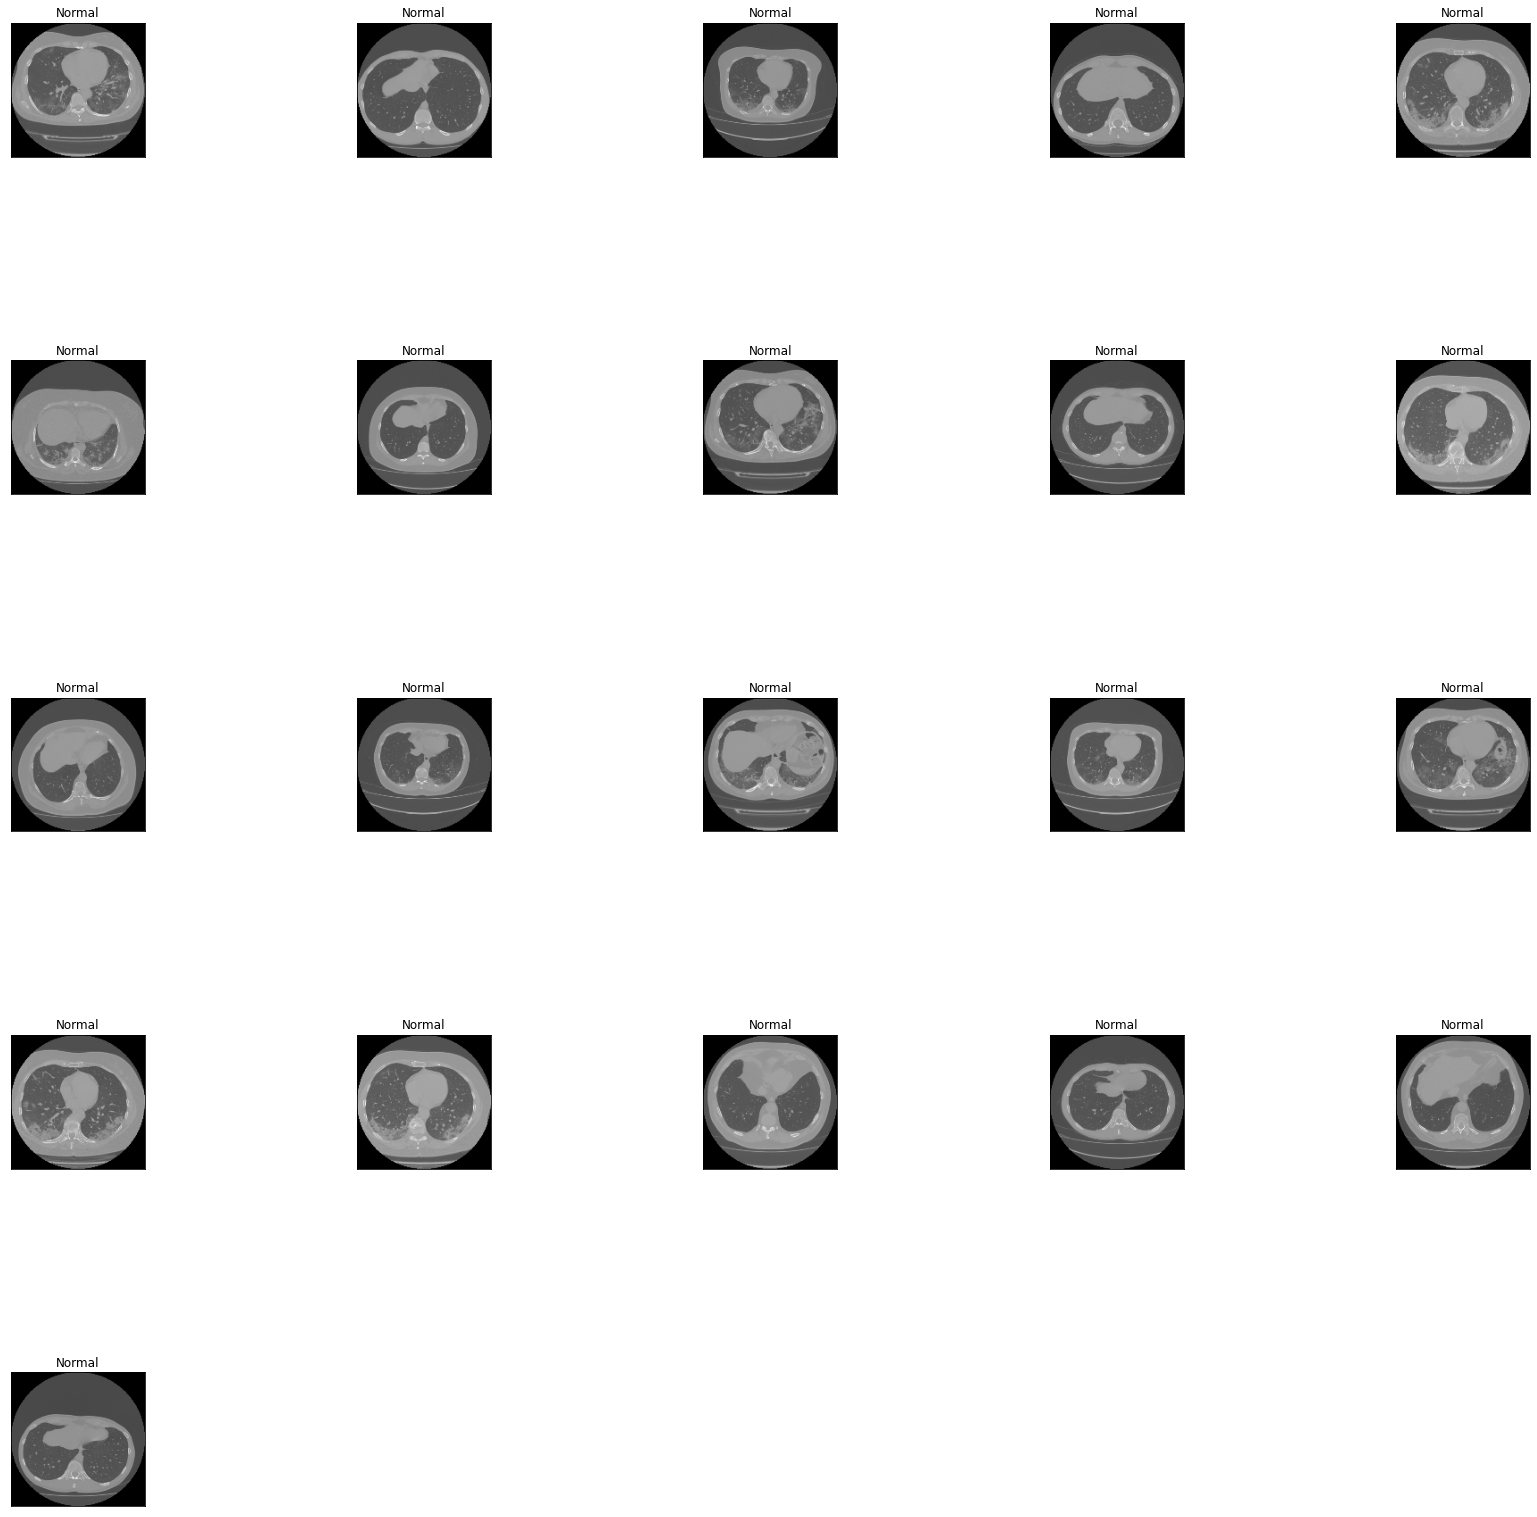

In [33]:
fig = plot.figure(figsize=(30, 30))
outer = gridspec.GridSpec(5, 5, wspace=0.2, hspace=0.2)

for i in range(21):
    inner = gridspec.GridSpecFromSubplotSpec(2, 1,subplot_spec=outer[i], wspace=0.1, hspace=0.1)
    rnd_number = randint(0,len(test_images))
    pred_image = np.array([test_images[i]])
    pred_prob = model.predict(pred_image)[0]
    #print(pred_prob)
    for j in range(2):
        if (j%2) == 0:
            ax = plot.Subplot(fig, inner[j])
            ax.imshow(pred_image[0])
            if pred_prob <0.5:
               ax.set_title('Normal')
            else:
               ax.set_title('COVID-19')
            ax.set_xticks([])
            ax.set_yticks([])
            fig.add_subplot(ax)
fig.show()